In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
import warnings


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)

# Loading data
transcript_df = pd.read_csv('/content/drive/MyDrive/EDAIC/transcript_summary_all.csv')
groundtruth_df = pd.read_csv('/content/drive/MyDrive/EDAIC/GroundTruth Table.csv')
df = pd.merge(transcript_df, groundtruth_df,
              left_on='participant_id', right_on='Participant_ID')

In [ ]:
label_columns = ['PTSD_Label', 'Depression_Label', 'Appetite_Label',
                 'Agency_Label', 'Anxiety_Label', 'Sleep_Label']
non_feature_columns = ['participant_id', 'Participant_ID'] + label_columns
feature_columns = [c for c in df.columns if c not in non_feature_columns]

In [ ]:
# Compute MI scores
mi_all = pd.DataFrame(index=feature_columns)
for label in label_columns:
    X = df[feature_columns].values
    y = df[label].values
    mi = mutual_info_classif(X, y, discrete_features='auto', random_state=0)
    mi_all[label] = pd.Series(mi, index=feature_columns)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


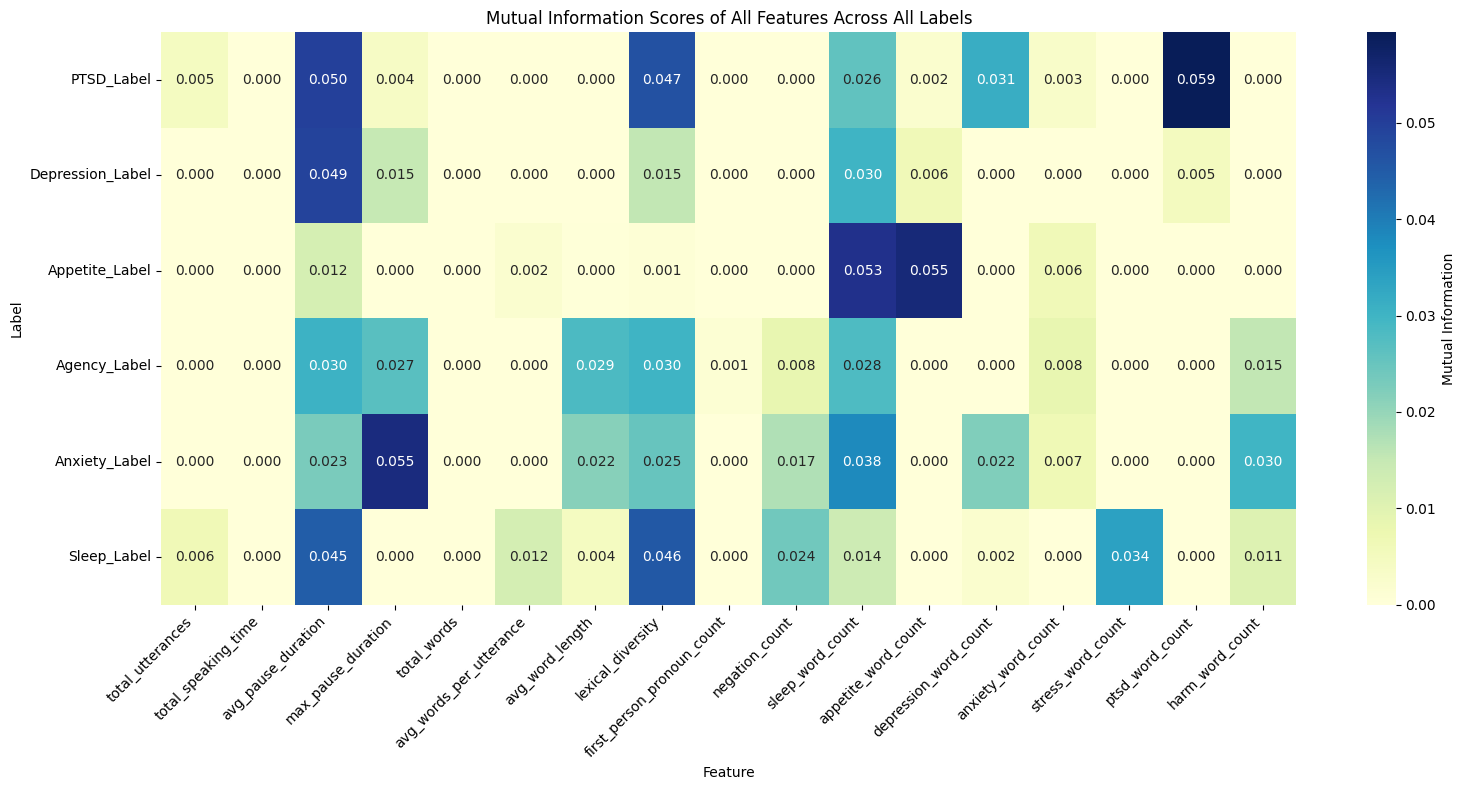

In [ ]:
plt.figure(figsize=(16, 8))
sns.heatmap(
    mi_all.T,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Mutual Information'}
)
plt.title("Mutual Information Scores of All Features Across All Labels")
plt.ylabel("Label")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# Selecting 5 features per label according to mi values
label_feature_map = {
    label: mi_all[label].sort_values(ascending=False).head(5).index.tolist()
    for label in label_columns
}


In [ ]:
# models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'MLP Classifier': MLPClassifier(hidden_layer_sizes=(16,),
                                    activation='relu',
                                    max_iter=500,
                                    random_state=0),
    'XGBoost Classifier': XGBClassifier(eval_metric='logloss',
                                         use_label_encoder=False,
                                         random_state=0),
    'SVM Classifier': SVC(kernel='rbf', probability=True, random_state=0),
    'Ridge Classifier': RidgeClassifier()
}

In [ ]:
def compute_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    sens = tp / (tp + fn) if tp + fn else 0
    spec = tn / (tn + fp) if tn + fp else 0
    return acc, sens, spec

def is_imbalanced(y, thr=0.4):
    vc = y.value_counts(normalize=True)
    return vc.min() < thr

In [ ]:
# Run 10x stratified 5 fold random state off
results = []
for rep in range(10):
    for label in label_columns:
        X = df[label_feature_map[label]]
        y = df[label]
        use_smote = is_imbalanced(y)

        skf = StratifiedKFold(n_splits=5, shuffle=True)

        # evaluate each base model
        for name, base in models.items():
            accs, senss, specs = [], [], []
            for tr, te in skf.split(X, y):
                X_tr, X_te = X.iloc[tr], X.iloc[te]
                y_tr, y_te = y.iloc[tr], y.iloc[te]
                if use_smote:
                    X_tr, y_tr = SMOTE(random_state=rep).fit_resample(X_tr, y_tr)
                mdl = clone(base)
                mdl.fit(X_tr, y_tr)
                y_pred = mdl.predict(X_te)
                a, s, sp = compute_metrics(y_te, y_pred)
                accs.append(a); senss.append(s); specs.append(sp)
            results.append({
                'Iteration': rep,
                'Label': label,
                'Model': name,
                'Accuracy': np.mean(accs),
                'Accuracy_std': np.std(accs),
                'Sensitivity': np.mean(senss),
                'Sensitivity_std': np.std(senss),
                'Specificity': np.mean(specs),
                'Specificity_std': np.std(specs),
            })

        # Voting ensemble (hard voting)
        ensemble = VotingClassifier(
            [(n, clone(m)) for n, m in models.items()],
            voting='hard'
        )
        accs, senss, specs = [], [], []
        for tr, te in skf.split(X, y):
            X_tr, X_te = X.iloc[tr], X.iloc[te]
            y_tr, y_te = y.iloc[tr], y.iloc[te]
            if use_smote:
                X_tr, y_tr = SMOTE(random_state=rep).fit_resample(X_tr, y_tr)
            ensemble.fit(X_tr, y_tr)
            y_pred = ensemble.predict(X_te)
            a, s, sp = compute_metrics(y_te, y_pred)
            accs.append(a); senss.append(s); specs.append(sp)
        results.append({
            'Iteration': rep,
            'Label': label,
            'Model': 'Voting Ensemble',
            'Accuracy': np.mean(accs),
            'Accuracy_std': np.std(accs),
            'Sensitivity': np.mean(senss),
            'Sensitivity_std': np.std(senss),
            'Specificity': np.mean(specs),
            'Specificity_std': np.std(specs),
        })

# Aggregate and print per-label summaries
results_df = pd.DataFrame(results)

for label in label_columns:
    print(f"\n----- Label: {label} -----")
    sub = results_df[results_df['Label'] == label]
    summary = sub.groupby('Model').agg({
        'Accuracy': ['mean','std'],
        'Sensitivity': ['mean','std'],
        'Specificity': ['mean','std']
    })
    for model in summary.index:
        m_acc, s_acc = summary.loc[model, ('Accuracy','mean')],  summary.loc[model, ('Accuracy','std')]
        m_sens, s_sens = summary.loc[model, ('Sensitivity','mean')], summary.loc[model, ('Sensitivity','std')]
        m_spec, s_spec = summary.loc[model, ('Specificity','mean')], summary.loc[model, ('Specificity','std')]
        print(f"{model}: "
              f"Accuracy {m_acc:.3f}±{s_acc:.3f}, "
              f"Sensitivity {m_sens:.3f}±{s_sens:.3f}, "
              f"Specificity {m_spec:.3f}±{s_spec:.3f}")


----- Label: PTSD_Label -----
Logistic Regression: Accuracy 0.569±0.016, Sensitivity 0.506±0.027, Specificity 0.597±0.019
MLP Classifier: Accuracy 0.585±0.023, Sensitivity 0.502±0.022, Specificity 0.623±0.029
Ridge Classifier: Accuracy 0.570±0.024, Sensitivity 0.508±0.026, Specificity 0.598±0.028
SVM Classifier: Accuracy 0.636±0.022, Sensitivity 0.443±0.032, Specificity 0.724±0.029
Voting Ensemble: Accuracy 0.592±0.019, Sensitivity 0.474±0.042, Specificity 0.647±0.021
XGBoost Classifier: Accuracy 0.584±0.031, Sensitivity 0.415±0.040, Specificity 0.662±0.037

----- Label: Depression_Label -----
Logistic Regression: Accuracy 0.537±0.025, Sensitivity 0.513±0.052, Specificity 0.544±0.029
MLP Classifier: Accuracy 0.598±0.013, Sensitivity 0.490±0.036, Specificity 0.632±0.010
Ridge Classifier: Accuracy 0.544±0.016, Sensitivity 0.545±0.038, Specificity 0.544±0.020
SVM Classifier: Accuracy 0.508±0.019, Sensitivity 0.424±0.051, Specificity 0.534±0.035
Voting Ensemble: Accuracy 0.573±0.037, Sens

In [ ]:
# PTSD_Label
# Model	Train Acc	Test Acc	Gap	Diagnosis
# Logistic Regression	0.584	0.568	0.016	small gap, low perf → under-fit
# MLP Classifier	0.655	0.596	0.059	modest gap
# Ridge Classifier	0.598	0.590	0.007	under-fit
# SVM Classifier	0.658	0.634	0.024	modest gap
# Voting Ensemble	0.705	0.609	0.095	slight over-fit
# XGBoost Classifier	1.000	0.591	0.409	severe over-fit

# Depression_Label
# Model	Train Acc	Test Acc	Gap	Diagnosis
# Logistic Regression	0.609	0.532	0.077	modest over-fit
# MLP Classifier	0.677	0.575	0.101	over-fit
# Ridge Classifier	0.607	0.531	0.076	modest over-fit
# SVM Classifier	0.577	0.502	0.075	modest over-fit
# Voting Ensemble	0.676	0.565	0.111	over-fit
# XGBoost Classifier	1.000	0.621	0.379	severe over-fit

# Appetite_Label
# Model	Train Acc	Test Acc	Gap	Diagnosis
# Logistic Regression	0.582	0.524	0.058	modest gap
# MLP Classifier	0.608	0.512	0.095	borderline over-fit
# Ridge Classifier	0.583	0.528	0.055	modest gap
# SVM Classifier	0.628	0.497	0.131	over-fit
# Voting Ensemble	0.630	0.520	0.110	over-fit
# XGBoost Classifier	0.999	0.552	0.447	severe over-fit

# Agency_Label
# Model	Train Acc	Test Acc	Gap	Diagnosis
# Logistic Regression	0.574	0.551	0.023	under-fit
# MLP Classifier	0.529	0.497	0.032	under-fit
# Ridge Classifier	0.574	0.551	0.023	under-fit
# SVM Classifier	0.565	0.516	0.050	modest gap
# Voting Ensemble	0.607	0.551	0.056	modest over-fit
# XGBoost Classifier	1.000	0.557	0.443	severe over-fit

# Anxiety_Label
# Model	Train Acc	Test Acc	Gap	Diagnosis
# Logistic Regression	0.617	0.599	0.018	under-fit
# MLP Classifier	0.591	0.559	0.033	under-fit
# Ridge Classifier	0.627	0.600	0.027	under-fit
# SVM Classifier	0.621	0.587	0.034	under-fit
# Voting Ensemble	0.677	0.596	0.081	modest over-fit
# XGBoost Classifier	1.000	0.571	0.429	severe over-fit

# Sleep_Label
# Model	Train Acc	Test Acc	Gap	Diagnosis
# Logistic Regression	0.592	0.585	0.007	under-fit
# MLP Classifier	0.625	0.571	0.054	modest gap
# Ridge Classifier	0.592	0.584	0.008	under-fit
# SVM Classifier	0.595	0.561	0.034	under-fit
# Voting Ensemble	0.632	0.587	0.045	modest over-fit
# XGBoost Classifier	1.000	0.568	0.432	severe over-fit

In [ ]:
records = []

for rep in range(10):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rep)
    for label in label_columns:
        X = df[label_feature_map[label]]
        y = df[label]
        need_smote = is_imbalanced(y)

        # helper to run one estimator through CV
        def eval_model(name, estimator, voting=False):
            tr_accs = []; tr_senss = []; tr_specs = []
            te_accs = []; te_senss = []; te_specs = []

            for train_idx, test_idx in skf.split(X, y):
                X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
                y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
                if need_smote:
                    X_tr, y_tr = SMOTE(random_state=rep).fit_resample(X_tr, y_tr)

                model = clone(estimator)
                model.fit(X_tr, y_tr)

                # test‐fold predictions
                y_pred_te = model.predict(X_te)
                a_te, s_te, sp_te = compute_metrics(y_te, y_pred_te)
                te_accs.append(a_te); te_senss.append(s_te); te_specs.append(sp_te)

                # train‐fold predictions
                y_pred_tr = model.predict(X_tr)
                a_tr, s_tr, sp_tr = compute_metrics(y_tr, y_pred_tr)
                tr_accs.append(a_tr); tr_senss.append(s_tr); tr_specs.append(sp_tr)

            records.append({
                'Iteration':   rep,
                'Label':       label,
                'Model':       name,
                'Train_Acc':   np.mean(tr_accs),
                'Train_Acc_σ': np.std(tr_accs),
                'Test_Acc':    np.mean(te_accs),
                'Test_Acc_σ':  np.std(te_accs),
                'Train_Sens':   np.mean(tr_senss),
                'Train_Sens_σ': np.std(tr_senss),
                'Test_Sens':    np.mean(te_senss),
                'Test_Sens_σ':  np.std(te_senss),
                'Train_Spec':   np.mean(tr_specs),
                'Train_Spec_σ': np.std(tr_specs),
                'Test_Spec':    np.mean(te_specs),
                'Test_Spec_σ':  np.std(te_specs),
            })

        # evaluate each base model
        for name, mdl in models.items():
            eval_model(name, mdl)

        # voting ensemble
        ensemble = VotingClassifier(
            [(n, clone(m)) for n, m in models.items()],
            voting='hard'
        )
        eval_model('Voting Ensemble', ensemble)

# build DataFrame and summary
df_res = pd.DataFrame(records)

for label in label_columns:
    print(f"\n----- Label: {label} -----")
    sub = df_res[df_res.Label == label].groupby('Model').agg({
        'Train_Acc':   ['mean','std'],
        'Test_Acc':    ['mean','std'],
    })
    # compute the train–test gap
    gap = sub['Train_Acc','mean'] - sub['Test_Acc','mean']
    summary = pd.DataFrame({
        'Train Acc (μ±σ)': sub['Train_Acc'].apply(lambda r: f"{r['mean']:.3f}±{r['std']:.3f}", axis=1),
        'Test  Acc (μ±σ)': sub['Test_Acc'].apply(lambda r: f"{r['mean']:.3f}±{r['std']:.3f}", axis=1),
        'Gap (Train–Test)': gap.round(3)
    })
    print(summary)


----- Label: PTSD_Label -----
                    Train Acc (μ±σ) Test  Acc (μ±σ)  Gap (Train–Test)
Model                                                                
Logistic Regression     0.584±0.008     0.568±0.028             0.016
MLP Classifier          0.655±0.010     0.596±0.013             0.059
Ridge Classifier        0.598±0.010     0.590±0.025             0.007
SVM Classifier          0.658±0.009     0.634±0.023             0.024
Voting Ensemble         0.705±0.009     0.609±0.025             0.095
XGBoost Classifier      1.000±0.000     0.591±0.019             0.409

----- Label: Depression_Label -----
                    Train Acc (μ±σ) Test  Acc (μ±σ)  Gap (Train–Test)
Model                                                                
Logistic Regression     0.609±0.010     0.532±0.023             0.077
MLP Classifier          0.677±0.011     0.575±0.026             0.101
Ridge Classifier        0.607±0.011     0.531±0.026             0.076
SVM Classifier        